<a href="https://colab.research.google.com/github/udaycodespace/Unsupervised-Anime-Recommendation-System/blob/main/Unsupervised_Anime_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn fuzzywuzzy python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.5 MB/s eta 0:00:00


In [2]:
#import required things
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches

In [5]:
# -----------------------------------------------------
# Stage 0: Load and Inspect the Data
# -----------------------------------------------------
# Load the anime dataset
file_path = "/content/anime_2025.csv"
df = pd.read_csv(file_path)

# Display first and last few rows to understand structure
print("--- First 5 Rows ---")
print(df.head(), "\n")

--- First 5 Rows ---
   anime_id                                          anime_url  \
0     52991  https://myanimelist.net/anime/52991/Sousou_no_...   
1      5114  https://myanimelist.net/anime/5114/Fullmetal_A...   
2      9253     https://myanimelist.net/anime/9253/Steins_Gate   
3     60022  https://myanimelist.net/anime/60022/One_Piece_...   
4     38524  https://myanimelist.net/anime/38524/Shingeki_n...   

                                           image_url  \
0  https://cdn.myanimelist.net/images/anime/1015/...   
1  https://cdn.myanimelist.net/images/anime/1208/...   
2  https://cdn.myanimelist.net/images/anime/1935/...   
3  https://cdn.myanimelist.net/images/anime/1455/...   
4  https://cdn.myanimelist.net/images/anime/1517/...   

                                 name                      english_name  \
0                   Sousou no Frieren     Frieren: Beyond Journey's End   
1    Fullmetal Alchemist: Brotherhood  Fullmetal Alchemist: Brotherhood   
2                   

In [6]:
print("--- Last 5 Rows ---")
print(df.tail(), "\n")

--- Last 5 Rows ---
       anime_id                                          anime_url  \
14995      1595  https://myanimelist.net/anime/1595/Inma_Daitos...   
14996     49943  https://myanimelist.net/anime/49943/Cosplay_Ch...   
14997     38812      https://myanimelist.net/anime/38812/Botsuraku   
14998     38914  https://myanimelist.net/anime/38914/Papa_no_March   
14999     21715  https://myanimelist.net/anime/21715/Makkuramor...   

                                               image_url  \
14995  https://cdn.myanimelist.net/images/anime/11/13...   
14996  https://cdn.myanimelist.net/images/anime/1384/...   
14997  https://cdn.myanimelist.net/images/anime/1301/...   
14998  https://cdn.myanimelist.net/images/anime/1553/...   
14999  https://cdn.myanimelist.net/images/anime/9/572...   

                                                    name  english_name  score  \
14995                          Inma Daitoshi: Beast City    Beast City   5.57   
14996  Cosplay Change: Pure-kei Josh

In [7]:
# -----------------------------------------------------
# Stage 1: Parse and Clean Genre Information
# -----------------------------------------------------
def parse_genres(genre_str):
    """
    Convert various genre formats into a Python list of genre names.
    Handles semicolon-separated strings or literal-eval list-like strings.
    """
    try:
        # If semicolon-separated
        if isinstance(genre_str, str) and ";" in genre_str:
            return [g.strip() for g in genre_str.split(";") if g.strip()]
        # If Python list-like string: e.g. "[{'id': 1, 'name': 'Action'}, ...]"
        genres = ast.literal_eval(genre_str)
        if isinstance(genres, list):
            return [g.get('name') for g in genres if isinstance(g, dict) and g.get('name')]
    except Exception:
        pass
    return []

# Create a new column of parsed genre lists
df['genre_list'] = df['genres'].fillna('').apply(parse_genres)

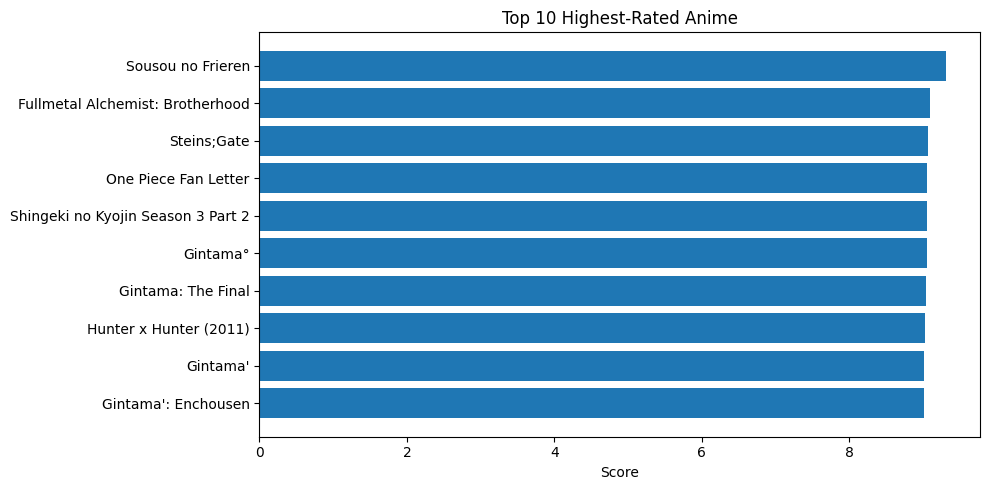

In [9]:
# Bar chart of top 10 anime by score
if 'score' in df.columns:
    top_rated = df[['name', 'score']].dropna().sort_values('score', ascending=False).head(10)
    plt.figure(figsize=(10,5))
    plt.barh(top_rated['name'][::-1], top_rated['score'][::-1])
    plt.xlabel('Score')
    plt.title('Top 10 Highest-Rated Anime')
    plt.tight_layout()
    plt.show()


In [11]:
# -----------------------------------------------------
# Stage 3: Feature Engineering for Clustering
# -----------------------------------------------------
# 1. One-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# 2. Scale numeric features (score, popularity/members)
numeric_cols = []
if 'score' in df.columns: numeric_cols.append('score')
if 'members' in df.columns: numeric_cols.append('members')
numeric_df = df[numeric_cols].fillna(0)
scaled_vals = MinMaxScaler().fit_transform(numeric_df)
scaled_df = pd.DataFrame(scaled_vals, columns=[f"{c}_scaled" for c in numeric_cols])

# Combine all features into a single DataFrame
features = pd.concat([genre_df, scaled_df], axis=1)


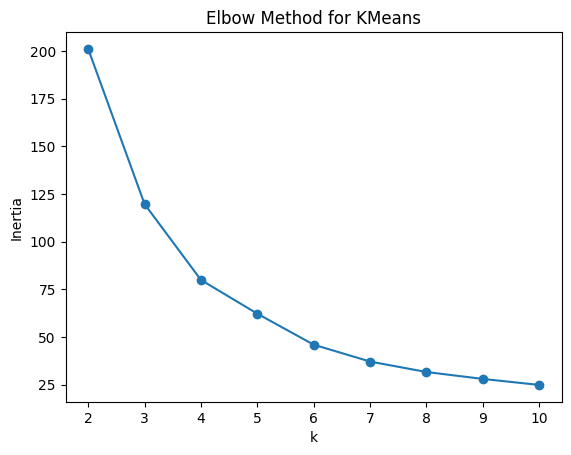

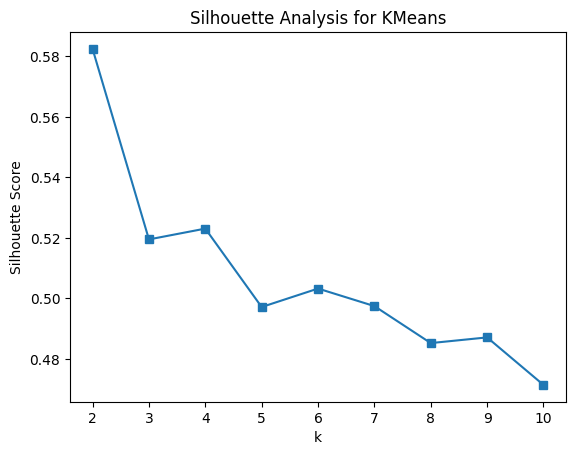

In [12]:
# -----------------------------------------------------
# Stage 4: Determine Optimal Number of Clusters
# -----------------------------------------------------
inertia_list = []
silhouette_list = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(features)
    inertia_list.append(km.inertia_)
    silhouette_list.append(silhouette_score(features, labels))

# Plot Elbow Method
plt.figure()
plt.plot(list(k_range), inertia_list, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()

# Plot Silhouette Scores
plt.figure()
plt.plot(list(k_range), silhouette_list, marker='s')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for KMeans')
plt.show()


In [13]:
# Choose k with highest silhouette score
best_k = k_range[int(np.argmax(silhouette_list))]
print(f"Optimal number of clusters: {best_k}")

Optimal number of clusters: 2


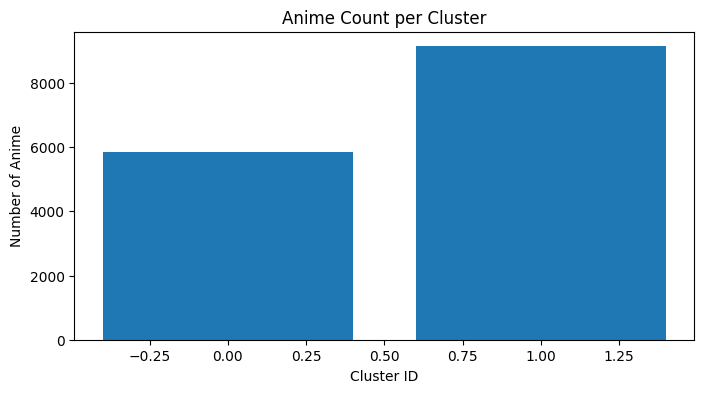

In [14]:
# -----------------------------------------------------
# Stage 5: Fit Final KMeans and Label Data
# -----------------------------------------------------
km_final = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = km_final.fit_predict(features)

# Visualize cluster sizes
cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Anime')
plt.title('Anime Count per Cluster')
plt.show()

In [18]:
# -----------------------------------------------------
# Stage 6: Build Recommendation Function
# -----------------------------------------------------
# Precompute similarity matrix for fast lookups
similarity_matrix = cosine_similarity(features)
indices = pd.Series(df.index, index=df['name']).drop_duplicates()

def recommend_anime(title, n=5):
    """
    Recommend anime similar to 'title' based on cluster features.
    Handles empty titles, typos via fuzzy matching, and absent entries.
    """
    if not isinstance(title, str) or not title.strip():
        return "Error: Please provide a non-empty anime title."

    title_clean = title.strip()
    # Exact match (case-insensitive)
    matches = [t for t in indices.index if t.lower() == title_clean.lower()]
    # Fallback to fuzzy matching
    if not matches:
        fuzzy = get_close_matches(title_clean, indices.index, n=1, cutoff=0.6)
        if fuzzy:
            matches = fuzzy
        else:
            return f"Error: No anime found for '{title}'. Please check spelling."

    idx = indices[matches[0]]
    sims = list(enumerate(similarity_matrix[idx]))
    sims_sorted = sorted(sims, key=lambda x: x[1], reverse=True)[1:n+1]
    rec_indices = [i[0] for i in sims_sorted]

    return df[['name', 'score']].iloc[rec_indices]

In [26]:
#TESTxCASE-1
print(recommend_anime(" ", n=5))

Error: Please provide a non-empty anime title.


In [19]:
#TESTxCASE-2
print(recommend_anime("Bleach", n=5))

                                        name  score
361    Re:Zero kara Hajimeru Isekai Seikatsu   8.24
7                     Hunter x Hunter (2011)   9.03
607                             Angel Beats!   8.05
13772                 Sin: Nanatsu no Taizai   5.76
11895                           Platinum End   6.03


In [25]:
#TESTxCASE-3
print(recommend_anime("Blx", n=5))

Error: No anime found for 'Blx'. Please check spelling.
